<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/baseline_lgb_2016_19_title_review_KFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r '/content/drive/MyDrive/Movies/data/mojo_japan/' '/content/'

!cp -r '/content/drive/MyDrive/Movies/data/metadata_filmarks/' '/content/'

In [3]:
!pip install japanize_matplotlib
import pandas as pd
import codecs 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import japanize_matplotlib

import warnings

import os
from tqdm import tqdm
import gc

In [4]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

#評価
from sklearn.metrics import r2_score
#r2_score(y_true, y_pred)

In [5]:
path = '/content/drive/MyDrive/Movies/preprocessed/'

In [6]:
def read_data(path, encode_type):
  
  with codecs.open(path, "r", encode_type, "ignore") as file:
    output = pd.read_csv(file, delimiter=",")
      
  return output

In [7]:
train = read_data(path+'train_2016-2018_title.csv', encode_type='utf-8')
test = read_data(path+'test_2019_title.csv', encode_type='utf-8')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5628) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


#reviewデータの結合

In [8]:
review = pd.read_csv('/content/drive/MyDrive/Movies/preprocessed/keiyousi_2016-2019.csv')

In [36]:
review_ = review.drop_duplicates()

In [37]:
train.shape, review_.shape

((642, 9063), (683, 489))

In [38]:
review_

,Title,Title(ja),title_url,keiyousi_contains_良い,keiyousi_contains_無い,keiyousi_contains_面白い,keiyousi_contains_凄い,keiyousi_contains_可愛い,keiyousi_contains_欲しい,keiyousi_contains_多い,keiyousi_contains_強い,keiyousi_contains_悪い,keiyousi_contains_楽しい,keiyousi_contains_素晴らしい,keiyousi_contains_怖い,keiyousi_contains_旨い,keiyousi_contains_美しい,keiyousi_contains_深い,keiyousi_contains_高い,keiyousi_contains_長い,keiyousi_contains_難しい,keiyousi_contains_優しい,keiyousi_contains_嬉しい,keiyousi_contains_辛い,keiyousi_contains_少ない,keiyousi_contains_悲しい,keiyousi_contains_早い,keiyousi_contains_切ない,keiyousi_contains_大きい,keiyousi_contains_新しい,keiyousi_contains_熱い,keiyousi_contains_若い,keiyousi_contains_久しい,keiyousi_contains_懐かしい,keiyousi_contains_酷い,keiyousi_contains_重い,keiyousi_contains_薄い,keiyousi_contains_弱い,keiyousi_contains_仕方無い,keiyousi_contains_小さい,...,keiyousi_contains_空々しい,keiyousi_contains_睦まじい,keiyousi_contains_細長い,keiyousi_contains_苦々しい,keiyousi_contains_捗々しい,keiyousi_contains_口惜しい,keiyousi_contains_そそっかしい,keiyousi_contains_姦しい,keiyousi_contains_まだるっこい,keiyousi_contains_名残惜しい,keiyousi_contains_甘辛い,keiyousi_contains_か黒い,keiyousi_contains_弛い,keiyousi_contains_恐れ多い,keiyousi_contains_気強い,keiyousi_contains_嘆かわしい,keiyousi_contains_肌寒い,keiyousi_contains_悪賢い,keiyousi_contains_人臭い,keiyousi_contains_えらしい,keiyousi_contains_妬ましい,keiyousi_contains_木暗い,keiyousi_contains_人悪い,keiyousi_contains_か細い,keiyousi_contains_しおらしい,keiyousi_contains_派手派手しい,keiyousi_contains_きな臭い,keiyousi_contains_はしこい,keiyousi_contains_せせこましい,keiyousi_contains_きしょい,keiyousi_contains_馴れ馴れしい,keiyousi_contains_青黒い,keiyousi_contains_疑り深い,keiyousi_contains_侘しい,keiyousi_contains_刺々しい,keiyousi_contains_雪深い,keiyousi_contains_疚しい,keiyousi_contains_いみじい,keiyousi_contains_脂っこい,keiyousi_contains_美々しい
0,Detective Conan: Zero the Enforcer,TRi [̎sl,https://filmarks.com/movies/77412,0.440860,0.365591,0.247312,0.161290,0.021505,0.064516,0.032258,0.010753,0.032258,0.021505,0.010753,0.000000,0.010753,0.000000,0.000000,0.021505,0.010753,0.129032,0.000000,0.053763,0.010753,0.010753,0.000000,0.000000,0.000000,0.043011,0.010753,0.021505,0.010753,0.032258,0.000000,0.010753,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Code Blue the Movie,ŃR[hEu[ -hN^[wً}~-,https://filmarks.com/movies/76162,0.479167,0.281250,0.083333,0.052083,0.031250,0.052083,0.020833,0.041667,0.020833,0.041667,0.041667,0.010417,0.020833,0.020833,0.062500,0.010417,0.010417,0.020833,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.020833,0.010417,0.010417,0.020833,0.000000,0.010417,0.010417,0.010417,0.020833,0.010417,0.000000,0.010417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jurassic World: Fallen Kingdom,WVbNE[h^̉,https://filmarks.com/movies/65519,0.326316,0.273684,0.136842,0.094737,0.147368,0.073684,0.031579,0.031579,0.052632,0.021053,0.021053,0.031579,0.000000,0.010526,0.052632,0.021053,0.000000,0.000000,0.000000,0.031579,0.042105,0.021053,0.031579,0.021053,0.010526,0.000000,0.031579,0.000000,0.000000,0.010526,0.000000,0.010526,0.000000,0.010526,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bohemian Rhapsody,{w~AEv\fB,https://filmarks.com/movies/73709,0.412371,0.329897,0.113402,0.154639,0.010309,0.030928,0.041237,0.030928,0.020619,0.030928,0.134021,0.000000,0.030928,0.010309,0.010309,0.010309,0.010309,0.010309,0.000000,0.030928,0.000000,0.000000,0.010309,0.020619,0.020619,0.010309,0.000000,0.010309,0.010309,0.010309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [39]:
train.loc[train['Title'].duplicated(), ['Title','Gross', 'Total Gross']]

,Title,Gross,Total Gross
1,Bohemian Rhapsody,63890010,115693295
3,Ralph Breaks the Internet,15092012,35032284
7,Dragon Ball Super: Broly,23640548,34644279
9,A Star Is Born,5773102,13500000
13,Fantastic Beasts: The Crimes of Grindelwald,40228080,58400000
...,...,...,...
631,The Secret Life of Pets,41733387,41733387
634,Fantastic Beasts and Where to Find Them,12837491,63700000
635,Fantastic Beasts and Where to Find Them,42900422,63700000
640,Your Name.,49762752,233794134


In [40]:
train.loc[train['Title']=='Bohemian Rhapsody', ['Title','Gross', 'Total Gross']]

,Title,Gross,Total Gross
0,Bohemian Rhapsody,51803285,115693295
1,Bohemian Rhapsody,63890010,115693295
251,Bohemian Rhapsody,51803285,115693295
252,Bohemian Rhapsody,63890010,115693295


In [41]:
review_ = review_.drop(['Title(ja)','title_url'], axis=1)

In [45]:
train = train.merge(review_, how='left', on='Title')
test = test.merge(review_, how='left', on='Title')

#前処理必要なカラム

> Theaters,Opening_Day,Country


> 今回，前処理されていないカラムname, Distributors

# 標準化が必要なカラム

> 'レビュー数', '平均スコア', 'Gross', 'Total Gross',    'Theaters'

In [46]:
train[train['Theaters']=='-'].__len__()

281

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


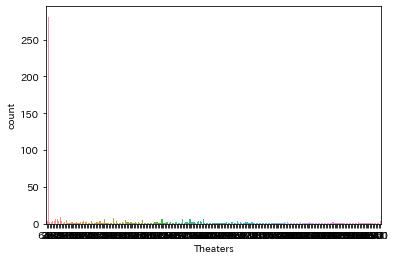

In [47]:
sns.countplot(train['Theaters'])

In [48]:
train['Theaters'].unique()

array(['645', '-', '365', '362', '468', '396', '366', '35', '746', '9',
       '62', '773', '375', '301', '568', '585', '371', '308', '709',
       '353', '322', '457', '775', '329', '360', '634', '332', '313', '1',
       '676', '291', '785', '347', '444', '682', '574', '970', '5', '128',
       '8', '596', '299', '156', '341', '314', '455', '745', '431', '705',
       '300', '275', '636', '342', '312', '4', '296', '331', '285', '696',
       '728', '6', '326', '252', '765', '406', '306', '198', '685', '756',
       '401', '302', '251', '148', '69', '59', '155', '273', '394', '52',
       '65', '196', '40', '150', '56', '246', '464', '180', '86', '120',
       '161', '33', '188', '34', '7', '210', '27', '101', '12', '50',
       '15', '16', '99', '25', '10', '483', '2', '22', '461', '640',
       '789', '673', '323', '417', '463', '260', '337', '193', '432',
       '249', '127', '231', '207', '336', '425', '194', '182', '235',
       '199', '113', '359', '145', '45', '28', '75', '226'

In [49]:
def preprocess_Theaters(input_df:pd.DataFrame)->pd.DataFrame:
  output_df = input_df.copy()
  plt.figure(figsize=(25,10))
  sns.countplot(input_df.loc[input_df['Theaters']!='-', 'Theaters'].astype(int).sort_values())
  plt.xticks(rotation=90)
  plt.show()
  print('- of number : {}'.format(input_df[input_df['Theaters']=='-'].__len__()))
  mean_ = input_df.loc[input_df['Theaters']!='-','Theaters'].astype(int).mean()

  print(f'mean of Theaters:{int(mean_)}')
  output_df['Theaters'] = output_df['Theaters'].replace('-', mean_).astype(int)

  return output_df

def lable_encoding(input_df:pd.DataFrame, cat_cols:list)->pd.DataFrame:
  output_df = input_df.copy()
  # カテゴリ変数は出現順にLabelEncoding
  for c in cat_cols:
    _dict = {j:i for i,j in enumerate(input_df[c].unique())}
    output_df[c] = input_df[c].map(_dict)
    
  return output_df

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


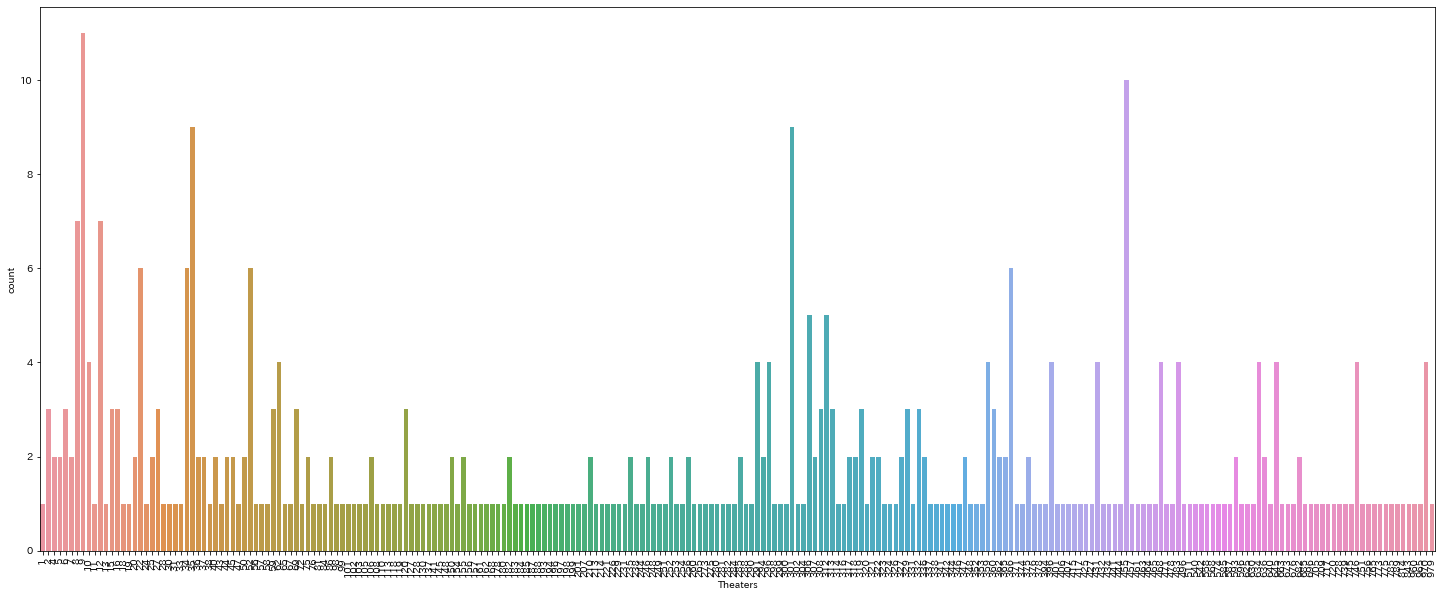

- of number : 407
mean of Theaters:274


In [50]:
data = pd.concat([train, test], axis=0).reset_index(drop=True)
data = preprocess_Theaters(data)

In [51]:
cols=['Country', 'Opening_Day']
data = lable_encoding(data, cols)

In [52]:
train = data[0:len(train)]
test = data[len(train):]

train.shape, test.shape

((662, 9549), (167, 9549))

In [53]:
train['Theaters'].describe()

count    662.000000
mean     281.129909
std      174.083582
min        1.000000
25%      248.250000
50%      274.000000
75%      308.000000
max      979.000000
Name: Theaters, dtype: float64

In [54]:
#アルゴリズムの方で分岐しているから必要ないかもしれない特徴量

def make_describe_col(input_df:pd.DataFrame, col:str):
  output_df = input_df.copy() 
  p_25 = output_df[col].describe()['25%']
  p_50 = output_df[col].describe()['50%']
  p_75 = output_df[col].describe()['75%']

  # 25%未満
  output_df[f'{col}_[x<25%]'] = output_df[col].apply(
      lambda x: 1 if x<p_25 else 0 
  )
  # 25%以上 50%未満
  output_df[f'{col}_[25<=x<50%]'] = output_df[col].apply(
      lambda x: 1 if x>=p_25 and x<p_50 else 0 
  )
  # 50%以上 75%未満
  output_df[f'{col}_[50<=x<75%]'] = output_df[col].apply(
      lambda x: 1 if x>=p_50 and x<p_75 else 0 
  )
  # 75%以上
  output_df[f'{col}_[75%<x]'] = output_df[col].apply(
      lambda x: 1 if x>=p_75 else 0 
  )

  return output_df

In [55]:
train = make_describe_col(train, 'Theaters')
train = make_describe_col(train, 'Time')

test = make_describe_col(test, 'Theaters')
test = make_describe_col(test, 'Time')

In [56]:
from sklearn import preprocessing

def normalization(df:pd.DataFrame, cols:list):
  output_df = df.copy()

  ss = preprocessing.StandardScaler()
  output_df[cols]= ss.fit_transform(output_df[cols])
  output_df[cols].add_suffix('_ss')

  return output_df 

In [57]:
""" use_columns = [
        'レビュー数',
        '平均スコア', 
        'Gross', 
        'Total Gross',
        'Theaters' ]

train = normalization(train, use_columns)
test = normalization(test, use_columns)"""

" use_columns = [\n        'レビュー数',\n        '平均スコア', \n        'Gross', \n        'Total Gross',\n        'Theaters' ]\n\ntrain = normalization(train, use_columns)\ntest = normalization(test, use_columns)"

# Training and Predicting 

##Making Folds

##Kfold

In [58]:
def create_folds(df, NUM_SPLITS, target):
    df = df.copy()
    df["kfold"] = -1 
    #fracで抽出する行の割合1は100%
    df = df.sample(frac=1).reset_index(drop=True)
    y = df[target].values   
    tkf = KFold(n_splits=NUM_SPLITS)
    for f, (t_, v_) in enumerate(tkf.split(X=df, y=y)):
        df.loc[v_,'kfold'] = f ###locより高速
    return df

# Custom Metric

In [59]:
from sklearn.metrics import mean_squared_log_error

def RMSLE(preds, data):
  y_true = data.get_label()
  score = np.sqrt(mean_squared_log_error(y_true, preds))
  return "RMSLE", score, True

from sklearn.metrics import mean_squared_error

def RMSE(preds, data):
  y_true = data.get_label() 
  score = np.sqrt(mean_squared_error(y_true, preds))

  return "RMSE", score, True

def metrics(preds, data):
    return [
        #accuracy(preds, data),
        #precision(preds, data),
        #recall(preds, data),
        #f1score_macro(preds, data),
        #RMSLE(preds, data),
        RMSE(preds, data)
    ]

In [60]:
from sklearn.metrics import r2_score

def trainer(train_df:pd.DataFrame, test_df:pd.DataFrame, target:str, fold:int, params:dict=None):
    df = train_df.copy()
    test = test_df.copy() 

    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

    del df 

    train_X = train_df.drop([target, 'kfold'], axis=1)
    #train_y = train_df[target]
    train_y = np.log1p(train_df[target])

    del train_df

    valid_X = valid_df.drop([target, 'kfold'], axis=1)
    #valid_y = valid_df[target]
    valid_y = np.log1p(valid_df[target])

    del valid_df


    dtrain = lgb.Dataset(train_X, train_y)
    dvalid = lgb.Dataset(valid_X, valid_y)

  
    if params is None:
        params = {}
  
    FIT_PARAMS_LGB = {
        "num_boost_round": 10000, 
        "early_stopping_rounds": 100, 
        "verbose_eval":100}

    evals_result = {}
    model = lgb.train(
      params, dtrain, **FIT_PARAMS_LGB,
      valid_names=['train', 'valid'], 
      valid_sets=[dtrain, dvalid],

      evals_result=evals_result,
      #feval=metrics
        )
  
    valid_pred = model.predict(valid_X,
                          num_iteration=model.best_iteration)
  
    test_pred = model.predict(test , axis=1,
                              num_iteration=model.best_iteration)
    
    #test['predict'] = np.stack(pred).mean(axis=0)

    
    RMSE = mean_squared_error(valid_y, valid_pred)**0.5
    print('Fold {} : RMSE {}'.format(fold, RMSE))
    
    R2 = r2_score(valid_y, valid_pred)
    print('Fold {} : R2 {}'.format(fold, R2))

    #model.save_model('/content/drive/MyDrive/SIGNATE_intern/model/lgb_fold{}.txt'.format(fold),
    #                 num_iteration=model.best_iteration)

    #model = lgb.Booster(model_file='*****.txt') で読み込める
    gc.collect()

    return valid_pred, test_pred, RMSE, evals_result, model

In [61]:
def create_folds(df:pd.DataFrame, target:str, NUM_SPLITS:int ):
    RANDOM_SEED=1
    df = df.copy()
    df["kfold"] = -1 
    #fracで抽出する行の割合1は100%
    df = df.sample(frac=1).reset_index(drop=True)
    y = df[target].values 
    kf = KFold(n_splits=NUM_SPLITS, random_state=RANDOM_SEED)
    for f, (t_, v_) in enumerate(kf.split(X=df)):
        df.loc[v_,'kfold'] = f 
    return df

#目的変数と説明変数の設定




In [62]:
#レビュー，平均スコアを含める場合
#drop_cols=['Title','Title(ja)','directors','writers','casts']

#----------------------------------------------------------------
#レビュー，平均スコアを含めない場合
drop_cols=['Title','Title(ja)','directors','writers','casts','レビュー数','平均スコア']

In [63]:
#train['Gross_log1p'] = train['Gross'].values
#train['Total Gross_log1p'] = train['Total Gross'].values

#y2 = np.log1p(y2)
#y = np.log1p(y)
#train = train.drop(drop_cols, axis=1)
#test = test.drop(drop_cols, axis=1)

In [76]:
#Total Grossを予測する場合
train_features = train.drop(drop_cols+['Gross'], axis=1) #'レビュー数','平均スコア'], axis=1)
test_features = test.drop(drop_cols+['Gross'], axis=1)     #'レビュー数','平均スコア'], axis=1)

#Grossを予測する場合
#train_features = train.drop(drop_cols+['Total Gross'], axis=1)#'レビュー数','平均スコア'], axis=1)
#test_features = test.drop(drop_cols+['Total Gross'], axis=1)  #'レビュー数','平均スコア'], axis=1)

In [78]:
#交差検証のための番号を振る

NUM_SPLITS = 3
target_col='Total Gross'
train_features = create_folds(train_features, target_col, NUM_SPLITS)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


#パラメータの設定

In [79]:
# 回帰分析にして学習させる
params = {
    'objective': 'regression',    'metric':'rmse', #'metric':'None', 
    'learning_rate': 0.005,    'max_depth': -1,
    'num_leaves': 30,    'max_bin': 31,
    'colsample_bytree': 0.8,    'subsample': 0.8,
    'nthread': -1,    'bagging_freq': 1,
    'verbose': -1,    'seed': 1,
    }

In [80]:
scores = []
test_preds = []
valid_preds = []
models = []
eval_results = []
for fold in range(NUM_SPLITS):
    print(f"fold {fold}", "-"*70)
    valid_pred, test_pred, score, evals_result, model = trainer(
        train_features, test_features, target_col, fold, params)
    
    valid_preds.append(valid_pred)
    test_preds.append(test_pred)
    scores.append(score) 
    models.append(model)

    eval_results.append(evals_result)


fold 0 ----------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.31667	valid's rmse: 1.35276
[200]	train's rmse: 1.06917	valid's rmse: 1.1764
[300]	train's rmse: 0.900616	valid's rmse: 1.08271
[400]	train's rmse: 0.781943	valid's rmse: 1.03178
[500]	train's rmse: 0.691146	valid's rmse: 1.00376
[600]	train's rmse: 0.621073	valid's rmse: 0.985455
[700]	train's rmse: 0.563909	valid's rmse: 0.973848
[800]	train's rmse: 0.5163	valid's rmse: 0.967455
[900]	train's rmse: 0.475264	valid's rmse: 0.962385
[1000]	train's rmse: 0.439598	valid's rmse: 0.959695
[1100]	train's rmse: 0.408732	valid's rmse: 0.956164
[1200]	train's rmse: 0.380337	valid's rmse: 0.955103
[1300]	train's rmse: 0.355304	valid's rmse: 0.953097
[1400]	train's rmse: 0.333195	valid's rmse: 0.952928
Early stopping, best iteration is:
[1349]	train's rmse: 0.344455	valid's rmse: 0.952813
Fold 0 : RMSE 0.9528128222792054
Fold 0 : R2 0.6

In [81]:
pred = np.array([model.predict(test_features.values) for model in models])
pred = np.mean(pred, axis=0)
#pred = np.expm1(pred)
pred = np.where(pred < 0, 0, pred)
#sub_df_kfold = pd.DataFrame({ 'Global_Sales': pred })
#sub_df_kfold.to_csv(os.path.join(OUTPUT_DIR, 'late_lgb_kfold_{}.csv'.format(NAME)), index=False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


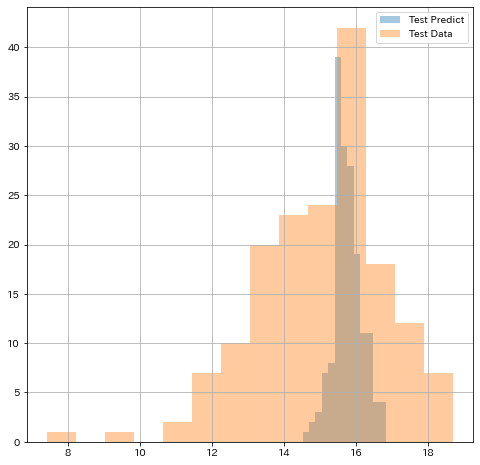

In [82]:
test_y=np.log1p(test['Total Gross'].values)

fig, ax = plt.subplots(figsize=(8, 8))

#変数を対数スケールで学習させなかった場合
sns.distplot(pred, label='Test Predict',kde=False)
sns.distplot(test_y, label='Test Data',kde=False)
#sns.distplot(oof, label='Out Of Fold')


#変数を対数スケールで学習させた場合
#sns.distplot(np.log1p(pred), label='Test Predict',kde=False)
#sns.distplot(np.log1p(test_y), label='Test Data',kde=False)
#sns.distplot(oof, label='Out Of Fold')

ax.legend()
ax.grid()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


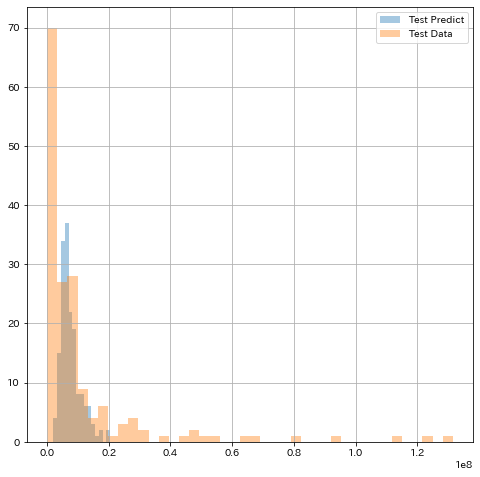

In [83]:
test_y=test['Total Gross'].values

fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.expm1(pred), label='Test Predict', kde=False)
sns.distplot(test_y, label='Test Data', kde=False)
#sns.distplot(oof, label='Out Of Fold')

ax.legend()
ax.grid()
plt.show()

In [84]:
import matplotlib.pyplot as plt 
%matplotlib inline 
def yyplot(y_obs, y_pred):
  yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
  ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
  fig = plt.figure(figsize=(6,6))
  plt.scatter(y_obs, y_pred)
  plt.plot([ymin - yrange*0.01, ymax + yrange*0.01],[ymin - yrange * 0.01, ymax + yrange * 0.01])
  plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
  plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
  plt.xlabel('y_obserbed', fontsize=24)
  plt.ylabel('y_predicted', fontsize=24)
  plt.title('yyplot', fontsize=24)
  plt.tick_params(labelsize=16)
  plt.show() 

  return fig

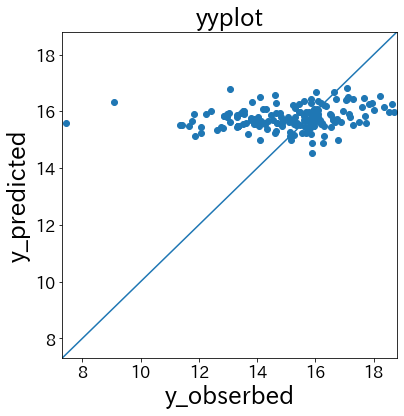

In [85]:
test_y=test['Total Gross'].values

fig = yyplot(np.log1p(test_y), pred)

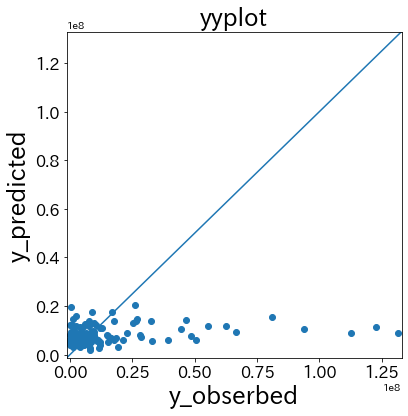

In [86]:
fig = yyplot(test_y, np.expm1(pred))

In [87]:
#決定係数
#r2_score(y_true, y_pred)
print(r2_score(test_y, np.expm1(pred)))

0.031601952122123356


In [88]:
t_y=np.log1p(test_y)
p_y=pred
#print(len(t_y),len(p_y))
print(r2_score(t_y, p_y))

-0.10034858997197516


In [97]:
def show_evals_result(evals_result:dict, fold:int):

    #rmse
    eval_metric_rmse = evals_result['valid']['rmse']
    train_metric_rmse = evals_result['train']['rmse']

    """
    # 組み込みのメトリック
    eval_metric_logloss = evals_result['valid']['binary_logloss']
    train_metric_logloss = evals_result['train']['binary_logloss']

    # カスタムメトリック (Accuracy)
    eval_metric_acc = evals_result['valid']['accuracy']
    train_metric_acc = evals_result['train']['accuracy']

    # カスタムメトリック (Precision)
    eval_metric_prec = evals_result['valid']['precision']
    train_metric_prec = evals_result['train']['precision']

    # カスタムメトリック (recall)
    eval_metric_recall = evals_result['valid']['recall']
    train_metric_recall = evals_result['train']['recall']

    # カスタムメトリック (F1_macro)
    eval_metric_f1macro = evals_result['valid']['f1_macro']
    train_metric_f1macro = evals_result['train']['f1_macro']
    """


    # グラフにプロットする
    _, ax1 = plt.subplots(figsize=(8, 8))
    ax1.plot(eval_metric_rmse, label='valid logloss', c='y')
    ax1.plot(train_metric_rmse, label='train logloss', c='b')
    ax1.set_ylabel('root mean square error')
    ax1.set_xlabel('rounds')
    ax1.set_title(f'Result of fold {fold} ')
    ax1.legend()

    #ax2 = ax1.twinx()
    #ax2.plot(eval_metric_rmse, label='valid rmse')
    #ax2.plot(train_metric_rmse, label='train rmse')

    #ax2.plot(eval_metric_acc, label='valid accuracy')
    #ax2.plot(train_metric_acc, label='train accuracy')
    #ax2.plot(eval_metric_prec, label='valid precision')
    #ax2.plot(train_metric_prec, label='train precision')
    #ax2.plot(eval_metric_recall, label='valid recall')
    #ax2.plot(train_metric_recall, label='train recall')
    #ax2.plot(eval_metric_f1macro, label='valid f1_macro')
    #ax2.plot(train_metric_f1macro, label='train f1_macro')
    #ax2.set_ylabel('ratio')
    #ax2.legend()

    plt.grid()
    plt.show()

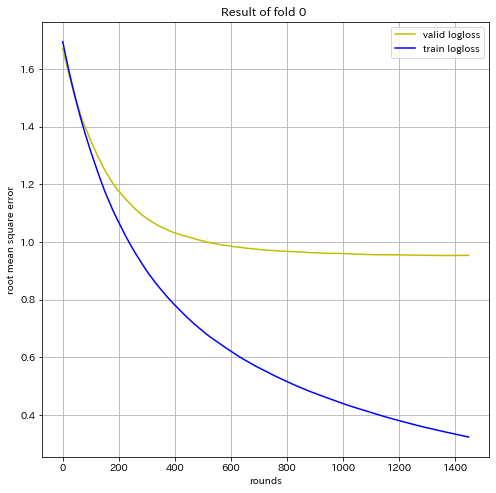

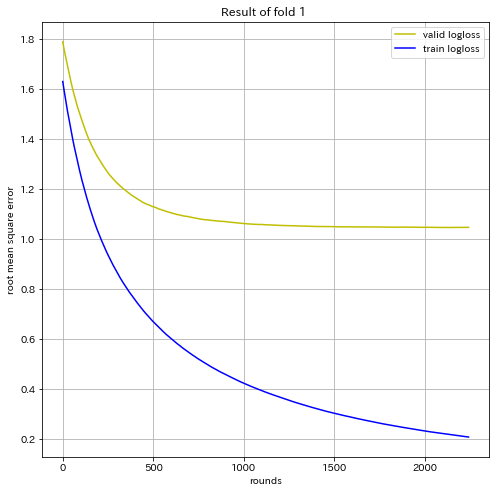

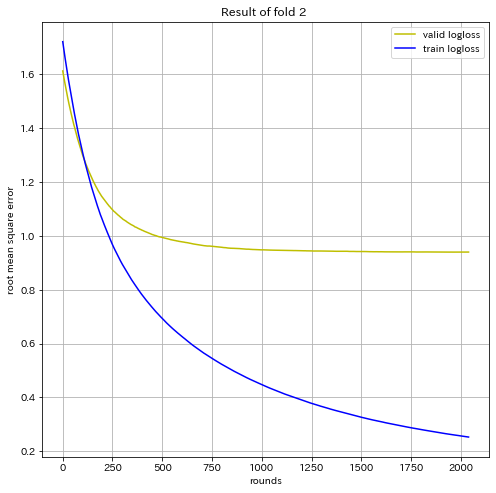

In [98]:
for i, eval_result in enumerate(eval_results):
  show_evals_result(eval_result, i)

In [99]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance('gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

   
    #feature_importance_df = feature_importance_df[feature_importance_df['feature_importance']>0]
    #sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance',  ax=ax, palette='ocean')
    #fig, ax = plt.subplots(figsize=(15, 20))

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(20, 20))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=15)
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

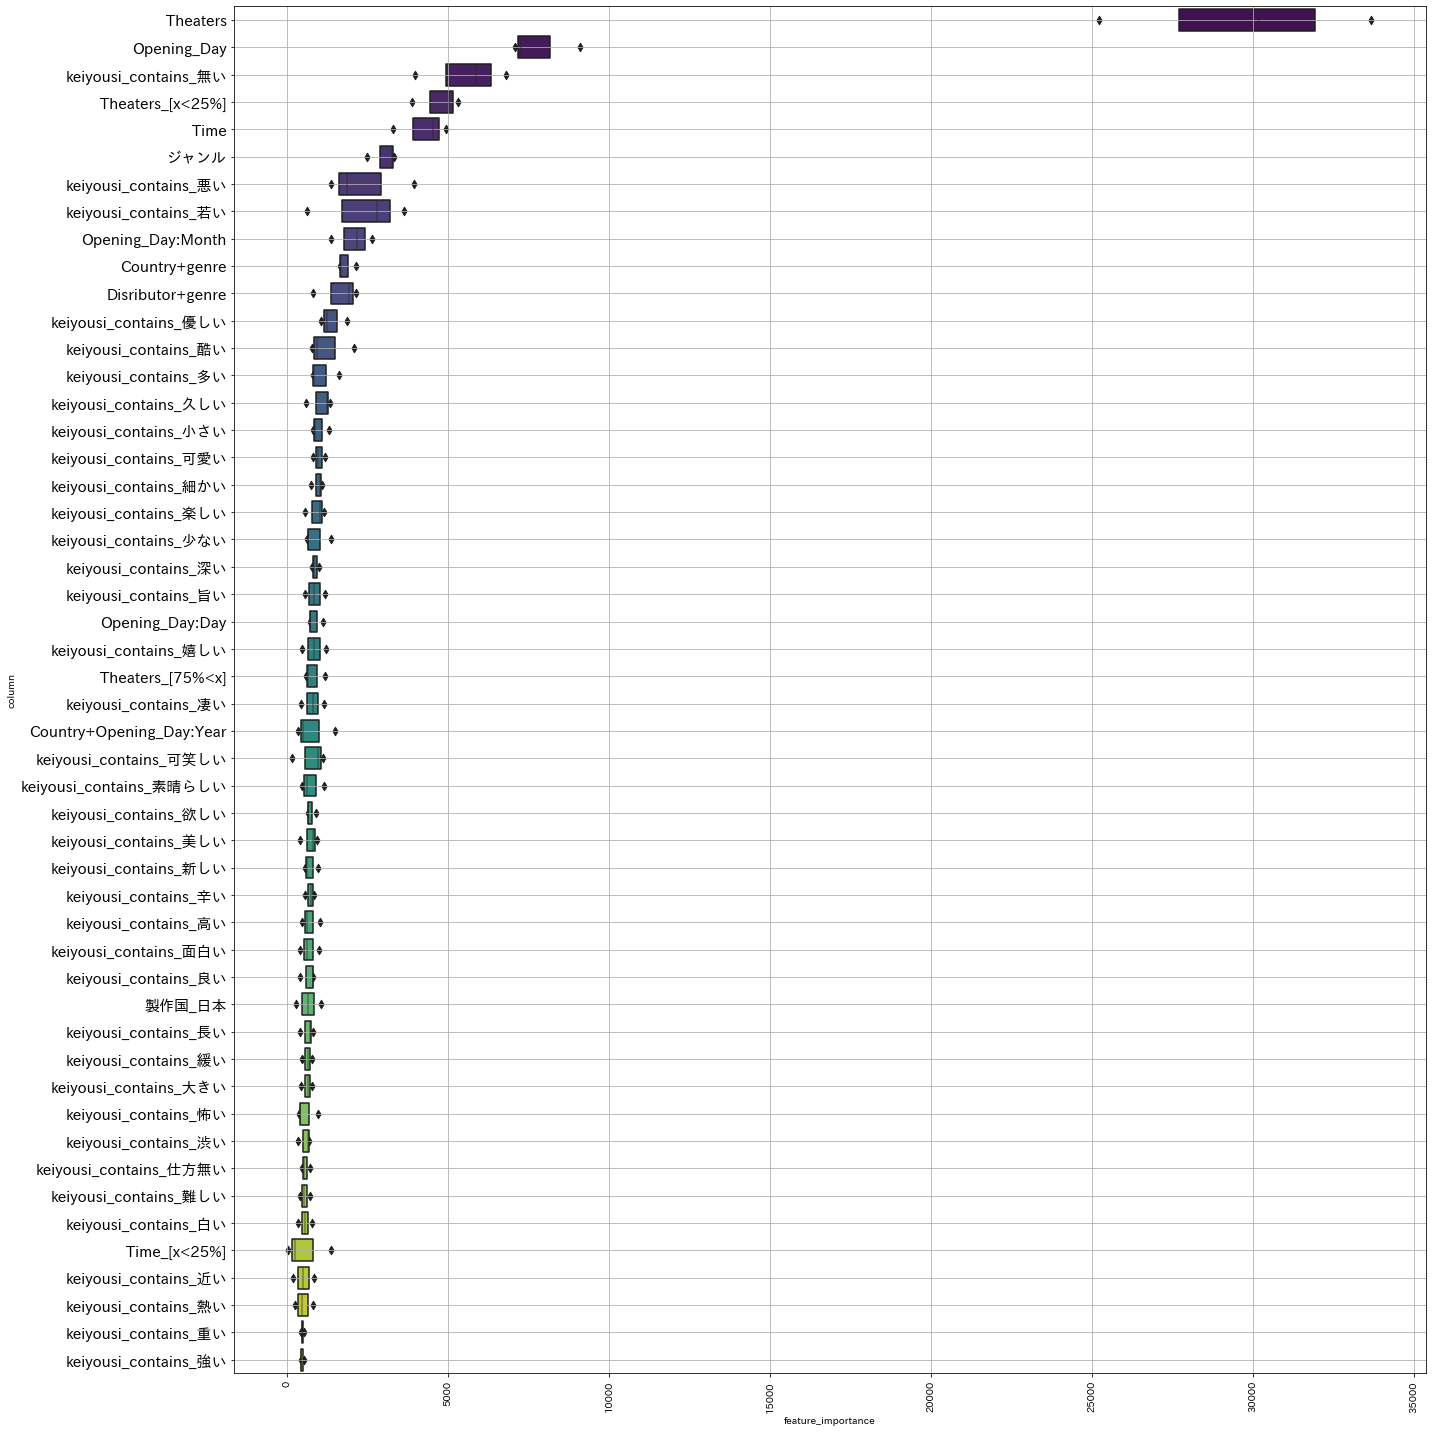

In [100]:
fig, ax, feature_importance_df = visualize_importance(models, train_features.drop([target_col, 'kfold'], axis=1))

In [109]:
pd.set_option('display.max_columns', 200)

feature_importance_df.groupby('column').sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False)[0:50]

,feature_importance
column,
Theaters,89074.224057
Opening_Day,23412.321792
keiyousi_contains_無い,16665.240713
Theaters_[x<25%],14194.149444
Time,12745.071982
ジャンル,9069.270447
keiyousi_contains_悪い,7173.813560
keiyousi_contains_若い,7023.360959
Opening_Day:Month,6175.073353


#ジャンルが重要視されていることが分かった．ジャンルに関する特徴量を作ると良いかもしれない．<br>
ジャンルに関するaggregrationなど

JSONDecodeError: ignored

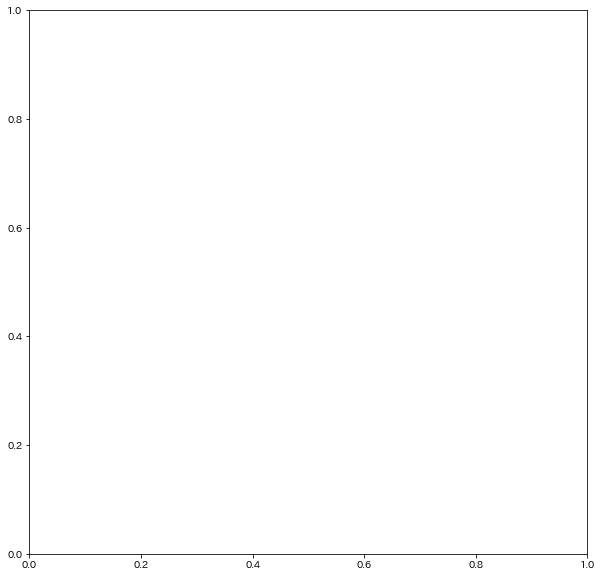

In [116]:
# 決定木を可視化
def display_tree(clf):
    ax = lgb.plot_tree(clf, tree_index=0, figsize=(10, 10), show_info=['split_gain'])
    plt.show()
    print('lightGBM　木の可視化')
    graph = lgb.create_tree_digraph(clf, tree_index=0, format='png', name='Tree')
    graph.render(view=True)

for i in models:
  display_tree(i)
  


In [119]:
#カラムに,が入るとエラーが出る
train[train.columns[3178]]

0      0
1      0
2      0
3      0
4      0
      ..
657    0
658    0
659    0
660    0
661    0
Name: ジョン・パーソン, Length: 662, dtype: int64

#追加データとして使えそう？？ 

https://gem-standard.com/news_releases/244